In [1]:
import glob
import numpy as np
import cv2
from PIL import Image
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt

filelist = glob.glob("./PictureStackImages/*.JPG")
filelist

['./PictureStackImages/8.JPG',
 './PictureStackImages/12.JPG',
 './PictureStackImages/5.JPG']

In [2]:
g = [1.79526731311, 1.85695064051, 1.69743757856]

In [3]:
def shutter_speed(filelist):
    speed_arr = []
    for file in filelist:
        exif_data = Image.open(file)._getexif()
        speed = float(10/exif_data[33434][1])
        speed_arr.append(speed)
    return speed_arr
speed_arr = shutter_speed(filelist)
log_speed = np.log(speed_arr)

a1 = float(speed_arr[0]/speed_arr[2])
a2 = float(speed_arr[1]/speed_arr[2])

In [4]:
im11 = cv2.imread(filelist[2])
im21 = cv2.imread(filelist[0])
im31 = cv2.imread(filelist[1])
img_list = [cv2.imread(file) for file in filelist]

In [5]:
width = 3264
length = 4928

wi_start = int((width - 500)/2)
len_start = int((length - 500)/2)

im1 = im11[wi_start:wi_start + 500, len_start:len_start + 500, :]
im2 = im21[wi_start:wi_start + 500, len_start:len_start + 500, :]
im3 = im31[wi_start:wi_start + 500, len_start:len_start + 500, :]

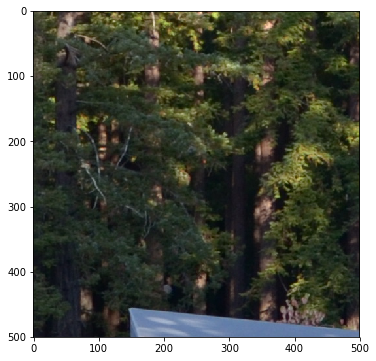

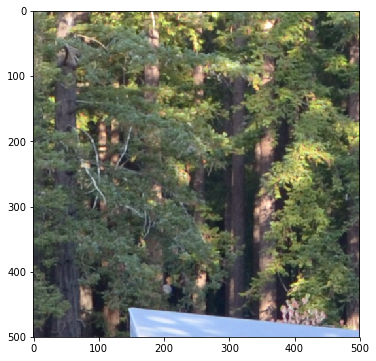

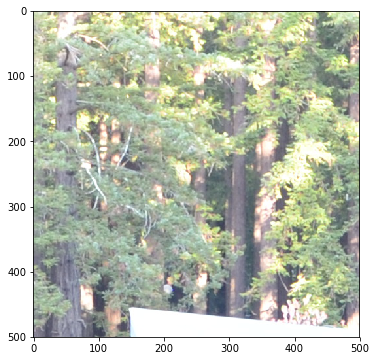

In [6]:
plt.figure(figsize=(12,6)); plt.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)); plt.show()
plt.figure(figsize=(12,6)); plt.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)); plt.show()
plt.figure(figsize=(12,6)); plt.imshow(cv2.cvtColor(im3, cv2.COLOR_BGR2RGB)); plt.show()

In [7]:
im1b = np.zeros(im1.shape, np.float32)
im2b = np.zeros(im1.shape, np.float32)
im3b = np.zeros(im1.shape, np.float32)

for i in range(3):
    im1b[:,:,i] = np.power(im1[:,:,i],g[i])
    im2b[:,:,i] = np.power(im2[:,:,i],g[i])
    im3b[:,:,i] = np.power(im3[:,:,i],g[i])

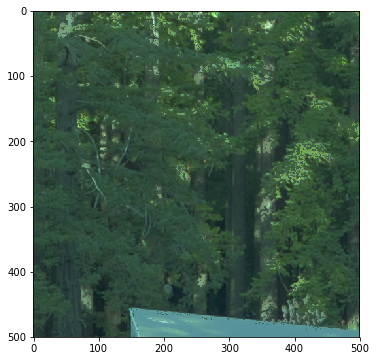

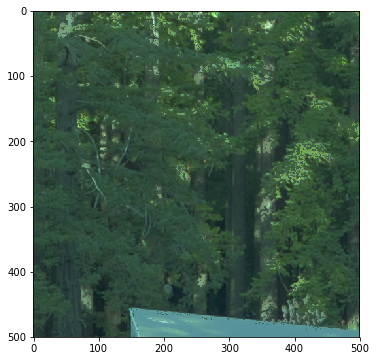

In [8]:
hdr_im1 = np.zeros(im1.shape, np.float32)
hdr_im1b = np.zeros(im1.shape, np.float32)
for i in range(im1.shape[0]):
    for j in range(im1.shape[1]):
        if im3[i,j,0] < 255 and im3[i,j,1] < 255 and im3[i,j,2] < 255:
            hdr_im1[i,j,:] = im3[i,j,:]/a2
            hdr_im1b[i,j,:] = im3b[i,j,:]/a2
        elif im2[i,j,0] < 255 and im2[i,j,1] < 255 and im2[i,j,2] < 255:
            hdr_im1[i,j,:] = im2[i,j,:]/a1
            hdr_im1b[i,j,:] = im2b[i,j,:]/a1  
        else:
            hdr_im1[i,j,:] = im1[i,j,:]
            hdr_im1b[i,j,:] = im1b[i,j,:]  
            
# plt.figure(figsize=(12,6)); plt.imshow(cv2.cvtColor(hdr_im1, cv2.COLOR_BGR2RGB)); plt.show() 

tonemap1 = cv2.createTonemapDurand(gamma=2.2)
res_debvec = tonemap1.process(hdr_im1b.copy())
res_debvec_8bit = np.clip(res_debvec*255, 0, 255).astype('uint8')
plt.figure(figsize=(12,6)); plt.imshow(cv2.cvtColor(res_debvec_8bit, cv2.COLOR_BGR2RGB)); plt.show() 
# cv2.imwrite("./TonemappedImages/hdr1_debve.jpg", res_debvec_8bit)

merge_mertens = cv2.createMergeMertens()
res_mertens = merge_mertens.process(img_list)
res_mertens_8bit = np.clip(res_mertens*255, 0, 255).astype('uint8')
plt.figure(figsize=(12,6)); plt.imshow(cv2.cvtColor(res_debvec_8bit, cv2.COLOR_BGR2RGB)); plt.show() 
# cv2.imwrite("./TonemappedImages/hdr1_fusion_mertens.jpg", res_mertens_8bit)


In [9]:
hdr_im1b

array([[[ 3008.89916992,  5664.26464844,  2562.47167969],
        [ 3829.61767578,  6623.63525391,  2898.39306641],
        [ 2766.26928711,  5045.05712891,  2310.57226562],
        ..., 
        [  607.18823242,  1715.1932373 ,   633.19256592],
        [  622.3059082 ,  1759.90112305,   633.19256592],
        [  660.81890869,  1850.90673828,   649.56335449]],

       [[ 1534.23168945,  2337.4777832 ,   953.49298096],
        [ 1444.74316406,  2235.98339844,   915.27813721],
        [ 1314.99755859,  2103.8984375 ,   859.16595459],
        ..., 
        [  629.92651367,  1700.40869141,   655.05841064],
        [  684.41717529,  1850.90673828,   694.05438232],
        [  765.71374512,  2039.24987793,   733.9720459 ]],

       [[ 1200.83886719,  2055.32470703,   834.69702148],
        [ 1101.06237793,  1975.53356934,   798.54022217],
        [ 1014.55670166,  1866.28015137,   757.19244385],
        ..., 
        [  967.8571167 ,  2023.23327637,   828.62530518],
        [ 1005.13885498,  

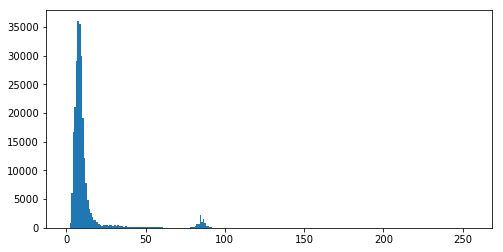

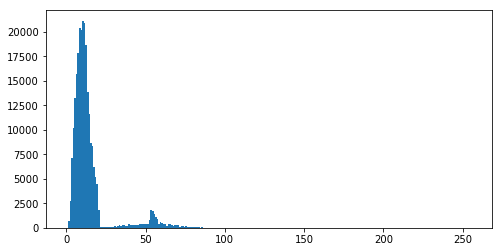

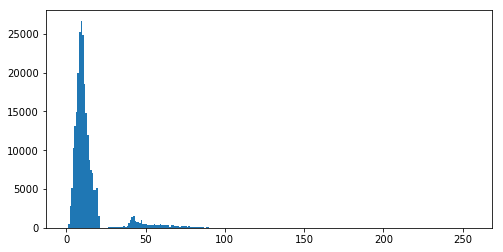

In [10]:
hdr_im1c = hdr_im1b
hdr_im1c[:,:,0] = hdr_im1b[:,:,0]/255**(g[0]-1)
hdr_im1c[:,:,1] = hdr_im1b[:,:,1]/255**(g[1]-1)
hdr_im1c[:,:,2] = hdr_im1b[:,:,2]/255**(g[2]-1)
plt.figure(figsize=(8,4)); plt.hist(hdr_im1c[:,:,0].ravel(),256,[0,256]); plt.show()
plt.figure(figsize=(8,4)); plt.hist(hdr_im1c[:,:,1].ravel(),256,[0,256]); plt.show()
plt.figure(figsize=(8,4)); plt.hist(hdr_im1c[:,:,2].ravel(),256,[0,256]); plt.show()

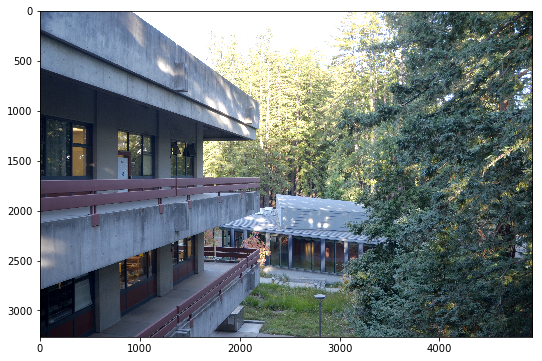

In [11]:
merge_mertens = cv2.createMergeMertens()
res_mertens = merge_mertens.process(img_list)
res_mertens_8bit = np.clip(res_mertens*255, 0, 255).astype('uint8')
plt.figure(figsize=(12,6)); plt.imshow(cv2.cvtColor(res_mertens_8bit, cv2.COLOR_BGR2RGB)); plt.show() 
# cv2.imwrite("./TonemappedImages/hdr1_fusion_mertens.jpg", res_mertens_8bit)

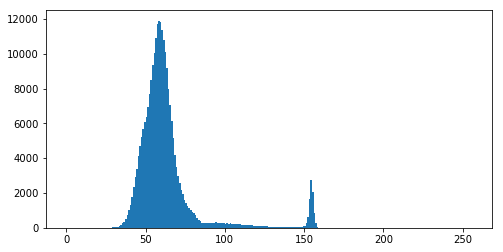

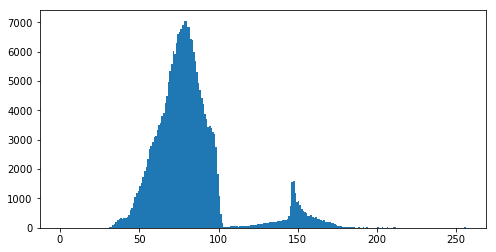

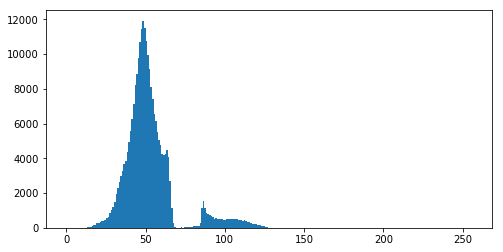

In [12]:
plt.figure(figsize=(8,4)); plt.hist(res_debvec_8bit[:,:,0].ravel(),256,[0,256]); plt.show()
plt.figure(figsize=(8,4)); plt.hist(res_debvec_8bit[:,:,1].ravel(),256,[0,256]); plt.show()
plt.figure(figsize=(8,4)); plt.hist(res_debvec_8bit[:,:,2].ravel(),256,[0,256]); plt.show()

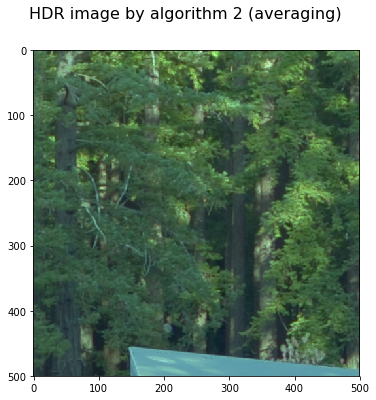

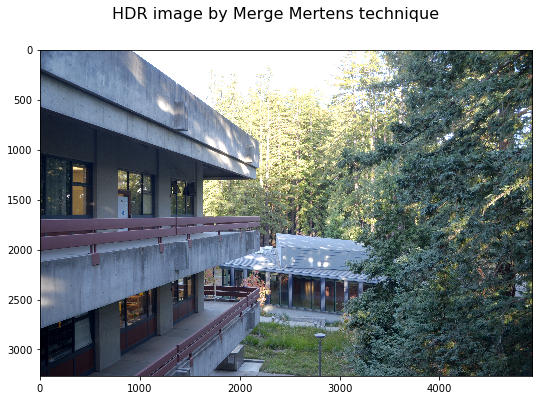

In [13]:
hdr_im2 = np.zeros(im1.shape, np.float32)
hdr_im2b = np.zeros(im1.shape, np.float32)
for i in range(im1.shape[0]):
    for j in range(im1.shape[1]):
        # Case 1: pixel is not saturated in any image
        if im3[i,j,0] < 255 and im3[i,j,1] < 255 and im3[i,j,2] < 255:
            hdr_im2[i,j,:] = (im3[i,j,:]/a2 + im2[i,j,:]/a1 + im1[i,j,:])/3
            hdr_im2b[i,j,:] = (im3b[i,j,:]/a2 + im2b[i,j,:]/a1 + im1b[i,j,:])/3
        # Case 2: pixel is not saturated in image 3 but not in image 2
        elif im2[i,j,0] < 255 and im2[i,j,1] < 255 and im2[i,j,2] < 255:
            hdr_im2[i,j,:] = (im2[i,j,:]/a1 + im1[i,j,:])/2
            hdr_im2b[i,j,:] = (im2b[i,j,:]/a1 + im1b[i,j,:])/2
        # Case 3: pixel is not saturated in image 3 but not in image 2
        else:
            hdr_im2[i,j,:] = im2[i,j,:]
            hdr_im2b[i,j,:] = im1b[i,j,:]  
            
#Tone-mapping: using Debvec Tone-mapping from the package provided by OpenCV with gamma = 2.2
#Reference: https://docs.opencv.org/3.4/d2/df0/tutorial_py_hdr.html

tonemap1 = cv2.createTonemapDurand(gamma=2.2)
res_debvec = tonemap1.process(hdr_im2b.copy())
res_debvec_8bit = np.clip(res_debvec*255, 0, 255).astype('uint8')
#Plot the resulting image:
plt.figure(figsize=(12,6)); plt.imshow(cv2.cvtColor(res_debvec_8bit, cv2.COLOR_BGR2RGB))
plt.suptitle('HDR image by algorithm 2 (averaging)', fontsize=16) ; plt.show()
#Write to file:
# cv2.imwrite("./TonemappedImages/hdr2.jpg", res_debvec_8bit)

#Using Merge Mertens technique:
img_list = [cv2.imread(file) for file in filelist]
merge_mertens = cv2.createMergeMertens()
res_mertens = merge_mertens.process(img_list)
res_mertens_8bit = np.clip(res_mertens*255, 0, 255).astype('uint8')
#Plot the resulting image:
plt.figure(figsize=(12,6)); plt.imshow(cv2.cvtColor(res_mertens_8bit, cv2.COLOR_BGR2RGB))
plt.suptitle('HDR image by Merge Mertens technique', fontsize=16) ; plt.show()
#Write to file:
# cv2.imwrite("./TonemappedImages/hdr_fusion_mertens.jpg", res_mertens_8bit)

In [14]:
hdr_im2b

array([[[ 3703.60742188,  6983.87988281,  3346.98974609],
        [ 4417.88183594,  7954.34667969,  3700.0390625 ],
        [ 3509.04589844,  6555.54199219,  3143.72338867],
        ..., 
        [  619.93017578,  2295.03735352,   817.90942383],
        [  803.94189453,  2584.04223633,   947.60797119],
        [  862.18389893,  2590.63720703,   941.84893799]],

       [[ 2596.94311523,  4557.17382812,  2178.52709961],
        [ 2466.11352539,  4273.42333984,  2082.25268555],
        [ 1977.30664062,  3616.69213867,  1756.0345459 ],
        ..., 
        [  686.62573242,  2502.15405273,   948.74017334],
        [ 1013.61907959,  3114.95898438,  1188.68225098],
        [ 1045.45446777,  3069.39868164,  1141.18408203]],

       [[ 1757.87744141,  3398.20825195,  1570.46777344],
        [ 1642.83300781,  3266.29418945,  1511.79821777],
        [ 1378.40881348,  2911.84643555,  1345.06738281],
        ..., 
        [  911.24023438,  3215.45727539,  1290.19934082],
        [ 1065.6953125 ,  

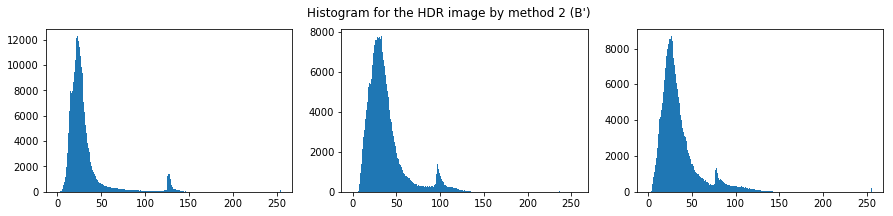

In [43]:
plt.figure(figsize=(15,3)); 
plt.subplot(1,3,1); plt.hist(hdr_im2[:,:,0].ravel(),256,[0,255]) 
plt.subplot(1,3,2); plt.hist(hdr_im2[:,:,1].ravel(),256,[0,256])
plt.subplot(1,3,3); plt.hist(hdr_im2[:,:,2].ravel(),256,[0,256])
plt.suptitle('Histogram for the HDR image by method 2 (B\') ')
plt.show()

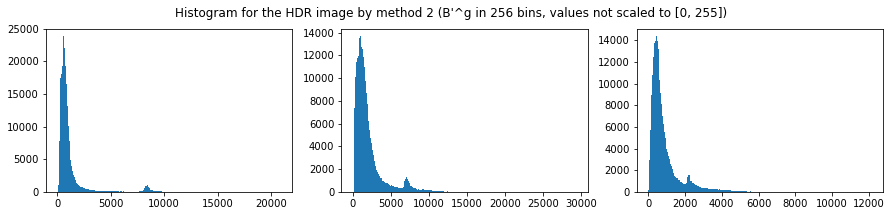

In [44]:
plt.figure(figsize=(15,3)); 
plt.subplot(1,3,1); plt.hist(hdr_im2b[:,:,0].ravel(),256,[0,255**g[0]]) 
plt.subplot(1,3,2); plt.hist(hdr_im2b[:,:,1].ravel(),256,[0,255**g[1]])
plt.subplot(1,3,3); plt.hist(hdr_im2b[:,:,2].ravel(),256,[0,255**g[2]])
plt.suptitle('Histogram for the HDR image by method 2 (B\'^g in 256 bins, values not scaled to [0, 255])')
plt.show()

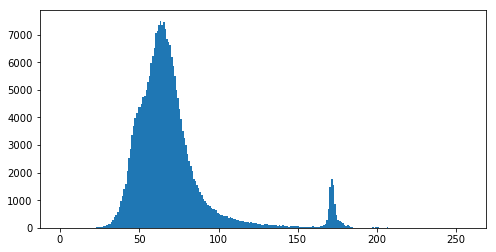

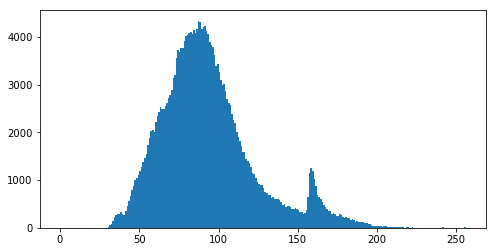

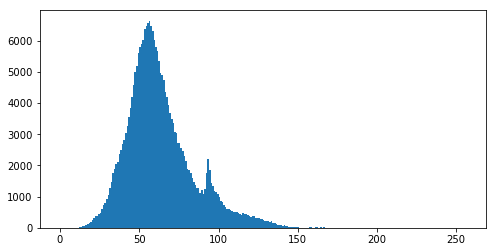

In [16]:
plt.figure(figsize=(8,4)); plt.hist(res_debvec_8bit[:,:,0].ravel(),256,[0,256]); plt.show()
plt.figure(figsize=(8,4)); plt.hist(res_debvec_8bit[:,:,1].ravel(),256,[0,256]); plt.show()
plt.figure(figsize=(8,4)); plt.hist(res_debvec_8bit[:,:,2].ravel(),256,[0,256]); plt.show()